# 梯度下降

超参数（Hyper-Parameter)是困扰神经网络训练的问题之一，因为这些参数不可通过常规方法学习获得。

神经网络经典五大超参数:学习率(Leraning Rate)、权值初始化(Weight Initialization)、网络层数(Layers)、单层神经元数(Units)、正则惩罚项（Regularizer|Normalization)

|    传统   | 加速 | 调整学习率 | 其他 | 
| :----------: | :---: |:---:|:---:|
| Batch Gradient Descent（BGD） |  Momentum |Adagrad|Proximal Gradient Descent（PGD）|
| Stochastic Gradient Descent（SGD） |  Nesterov accelerated gradient(NAG) |Adadelta|Restart技术|
| Mini-Batch Gradient Descent|||||


cite from 1: [机器之心](http://mp.weixin.qq.com/s?__biz=MzA3MzI4MjgzMw==&mid=2650720663&idx=3&sn=d9f671f77be23a148d1830448154a545&chksm=871b0de9b06c84ffaf260b9ba2a010108cca62d5ce3dcbd8c98c72c9f786f9cd460b27b496ca&mpshare=1&scene=2&srcid=1121mgll9exVL2Gia7trGTn7&from=timeline#wechat_redirect)
and [Sebastian Ruder's Blog](http://sebastianruder.com/optimizing-gradient-descent/index.html)



梯度下降的目标是最小化以$\theta$ 为参数的目标函数（objective function）$J(\theta)$, 沿着目标函数对应参数的梯度的反方向，升级模型参数。

> Gradient descent is a way to minimize an objective function $J(\theta)$ parameterized by a model's parameters $\theta \in R^d$ by updating the parameters in the opposite direction of the gradient of the objective function to the parameters

$$\theta=\theta-\eta * \frac{\partial J(\theta)}{\partial \theta}$$


## 例子
### 目标和数据

根据测试集数据，求解$y=ax_1^2+bx_2^2$中a，b的数值。下面代码中选取a=2 b=-1

测试集为键值对的形式，如$X=(1,2),y=-2$
### objective function 目标函数
若令$\theta=(a,b)$,$X=(x_1^2,x_2^2)$，则$y=\theta X$

目标函数：
$J(\theta)=\frac{1}{2}(\theta X-\hat{y})^2$

求解目标变成 $min_{\theta} \frac{1}{2}(\theta X-\hat{y})^2$

In [1]:
import scipy.io as sio
import seaborn
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 


In [2]:
# 生成测试数据

train=list(combinations([0.01*i for i in range(100)], 2))
label=[]
# 计算函数 2x_1^2-x_2^2
for i in train:
    label.append(2*i[0]**2 -1*i[1]**2)
print(np.shape(train))
print(train[:5])
print(label[:5])

(4950, 2)
[(0.0, 0.01), (0.0, 0.02), (0.0, 0.03), (0.0, 0.04), (0.0, 0.05)]
[-0.0001, -0.0004, -0.0009, -0.0016, -0.0025000000000000005]


In [4]:
# 绘制坐标
range_a = np.arange(-4, 4, 0.25)
range_b = np.arange(-4, 4, 0.25)
grid_a, grid_b = np.meshgrid(range_a, range_b)

In [19]:
# 计算参数空间内，每一个坐标所对应的函数值
def Grid_J(train,label,a,b):
    J=np.zeros(np.shape(a))
    for ind,i in enumerate(train):
        Z_pre=np.array((a*i[0]**2 + b*i[1]**2))
        Z=label[ind]
        # 计算 loss 函数
        J+=0.5*(Z_pre-Z)**2
    return J/len(train)

In [20]:
# 绘制参数空间中，目标函数的变化值
grid_J=Grid_J(train,label,grid_a,grid_b)

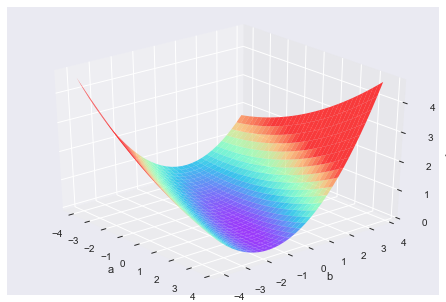

In [21]:
plt.clf()
fig = plt.figure()
ax = Axes3D(fig)
ax.set_zlabel('J') #坐标轴
ax.set_ylabel('b')
ax.set_xlabel('a')
# 具体函数方法可用 help(function) 查看，如：help(ax.plot_surface)
ax.plot_surface(grid_a, grid_b, grid_J, rstride=1, cstride=1,vmax=2, cmap='rainbow',alpha=0.75)
ax.view_init(30, 320)
plt.show()

# 三个变体

根据所使用的的数据量不同，梯度下降可以分为三个变体，三者对参数做更新的准确度和花费时间上面做了对应的取舍。

> Depending on the amount of data, we make a trade-off between the accuracy of the parameter update and the time it takes to perform an update.

## Batch Gradient Descent 批量梯度下降法

Calculate the gradients for __the whole dataset__ to perform just __one__ update

批量梯度下降需要对所有的数据计算梯度，只进行一次参数调整

伪码描述
```Python
for i in range(nb_epochs):
    params_grad = evaluate_gradient(loss_function, data, params)
    params = params - learning_rate * params_grad
```

特点:

* Intractable for datasets that don't fit in memory 

    > 因为需要一次性读取全部数据，所以对内存有较高要求


* Guaranteed to converge to the global minimum for convex error surfaces and to a local minimum for non-convex surfaces.
    > 优点是，对于"convex error surfaces"保证能够到达全局最小，对于"non-convex surfaces"保证能到达局部最小

* Slow
* Don't allow us to update our model __online__


In [22]:
# 定义计时函数
import time
import os
from functools import wraps  
def exeTime(func):
    def newFunc(*args, **args2):
        t0 = time.time()
        print("@%s, {%s} start" % (time.strftime("%X", time.localtime()), func.__name__))
        back = func(*args, **args2)
        print("@%s, {%s} end" % (time.strftime("%X", time.localtime()), func.__name__))
        print("@%.3fs taken for {%s}" % (time.time() - t0, func.__name__))
        return back
    return newFunc

In [24]:
# 计算目标函数的函数值和导数值
def dJ(train,a,b):
    tmp=a*train[0]**2+b*train[1]**2-(2*train[0]**2-train[1]**2)
    djda=tmp*train[0]
    djdb=tmp*train[1]
    return djda,djdb
def J(train,label,a,b):
    Z_pre=np.array((a*train[0]**2 + b*train[1]**2))
    Z =label
    J =0.5*(Z_pre-Z)**2
    return J

In [37]:
# Batch gradient descent
@exeTime
def Gradient_descent(train,label,a=4,b=4,tolerance=1e-3,maxiter=1000,alpha=1):
    # 参数的初始化
    pre_a=100;pre_b=100;iteration=0
    #记录参数的变化情况
    x=[];y=[];z=[]
    # 外层迭代，每次外层迭代就完整地一次数据集
    while(((abs(a-pre_a)>tolerance) and abs(b-pre_b)>tolerance) and iteration<maxiter):
        # 变量初始化
        iteration+=1;J_val=0;djda=0;djdb=0
        for ind,i in enumerate(train):
            # 将每个数据的计算结果相累加
            J_val+=J(i,label[ind],a,b)
            tmp1,tmp2=dJ(i,a,b)
            djda+=tmp1;djdb+=tmp2
        djda=djda/len(train); djdb=djdb/len(train)
        # 记录每一步的位置
        x.append(a);y.append(b);z.append(J_val/len(train))
        # 记录上一步的位置，用于判断迭代终止
        pre_a=a;pre_b=b
        # 梯度下降
        a-=alpha*djda;b-=alpha*djdb
    print ('a:',a); print ('b:',b); print ('iteration:',iteration)
    return x,y,z

# 误差变化曲线
def PlotErrorCurve(z,xlim=None):
    fig = plt.figure()
    plt.plot(z,c='b')
    if xlim:
        plt.xlim(0,xlim)
    plt.show()

In [35]:
x,y,z=Gradient_descent(train,label,tolerance=1e-6,a=-3,b=4)

@09:20:26, {Gradient_descent} start
a: 1.9999016998159789
b: -0.9999654241839734
iteration: 396
@09:20:32, {Gradient_descent} end
@5.379s taken for {Gradient_descent}


In [29]:
# 绘制梯度下降路径
def PlotPath(x,y,z,plota=grid_a, plotb=grid_b, plotJ=grid_J,zlim=None,angle=300,vmax=1,alpha=0.5):
    plt.clf()
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(plota, plotb, plotJ,rstride=1, cstride=2,vmax=1, cmap='rainbow',alpha=alpha)
    #坐标轴
    ax.set_zlabel('J'); ax.set_ylabel('b'); ax.set_xlabel('a'); ax.scatter(x,y,z,c='b')
    if zlim:
        ax.set_zlim(0, zlim)
#     plt.show()
    
    ax.view_init(30, angle)
    plt.draw()

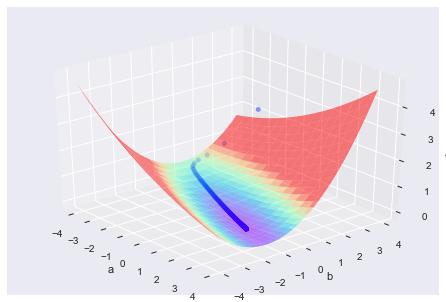

In [36]:
PlotPath(x,y,z,angle=320)

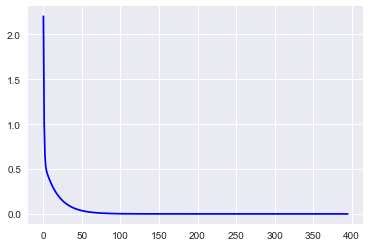

In [38]:
PlotErrorCurve(z)

## Stochastic Gradient Descent 随机梯度下降(SGD)

Stochastic gradient descent (SGD) in contrast performs a parameter update for each training example $x^{(i)}$ and label $y^{(i)}$

相比于批量梯度下降做一次参数更新要使用所有的训练集，随机梯度下降每使用一条训练数据就进行一次参数更新。

$\theta =\theta-\eta *\frac{\partial J(\theta;x^{(i)};y^{(i)})}{\partial \theta}$

伪码描述
```Python
for i in range(nb_epochs):
  np.random.shuffle(data)
  for example in data:
    params_grad = evaluate_gradient(loss_function, example, params)
    params = params - learning_rate * params_grad
```

In [39]:
@exeTime
def Stochastic_gradient_descent(train,label,a=4,b=4,tolerance=1e-6,maxiter=1000, alpha=1):
    pre_a=100; pre_b=100; iteration=0; x=[]; y=[]; z=[]
    while(((abs(a-pre_a)>tolerance) and abs(b-pre_b)>tolerance) and iteration<maxiter):
        iteration+=1
        index=list(range(len(train)))
        np.random.shuffle(index)
        for ind in index:
            J_val=J(train[ind],label[ind],a,b)
            djda,djdb=dJ(train[ind],a,b)
            # 记录上一步的位置，用于判断迭代终止
            pre_a=a; pre_b=b
            # 梯度下降
            a-=alpha*djda; b-=alpha*djdb
            # 记录每一步的位置
            x.append(a); y.append(b); z.append(J_val)
    print ('a:',a); print ('b:',b); print ('iteration:',iteration)
    return x,y,z

In [42]:
x,y,z= Stochastic_gradient_descent(train,label,tolerance=1e-3,a=-3,b=4)

@09:24:37, {Stochastic_gradient_descent} start
a: 2.0
b: -1.0
iteration: 1
@09:24:37, {Stochastic_gradient_descent} end
@0.022s taken for {Stochastic_gradient_descent}


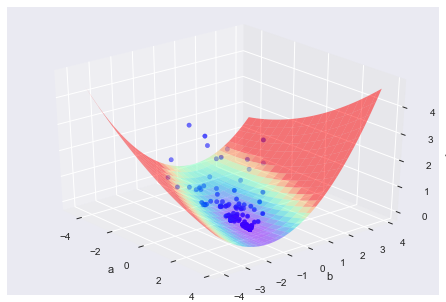

In [43]:
PlotPath(x,y,z,angle=320)

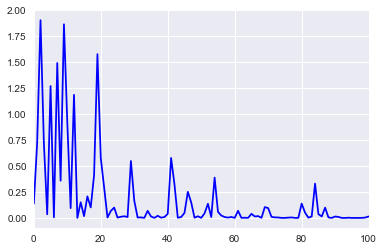

In [44]:
PlotErrorCurve(z,xlim=100)

## BGD and SGD 

当数据足够好的时候，使用SGD能够达到更快的收敛速率,方差小。

因为批量梯度下降法(BGD)在每次更新前，会对相似的样本求算梯度值，因而它在较大的数据集上的计算会有些冗余（redundant）。而随机梯度下降法通过每次更新仅对一个样本求梯度，去除了这种冗余的情况。因而，它的运行速度被大大加快，同时也能够「在线」学习。

相比批量梯度下降法的收敛会使目标函数落入一个局部极小值，SGD 收敛过程中的波动，会帮助目标函数跳入另一个可能的更小的极小值。另一方面，这最终会让收敛到特定最小值的过程复杂化，因为该方法可能持续的波动而不停止。但是，当我们慢慢降低学习率的时候，SGD 表现出了与批量梯度下降法相似的收敛过程，也就是说，对非凸函数和凸函数，必然会分别收敛到它们的极小值和最小值。

## Mini-Batch Gradient Descent 小批量梯度下降法

小批量梯度下降法集合了上述两种方法的优势，在每次更新中，对 n 个样本构成的一批数据，计算罚函数 J(θ)，并对相应的参数求导：

$\theta =\theta-\eta *\frac{\partial J(\theta;x^{(i:i+n)};y^{(i:i+n)})}{\partial \theta}$

这种方法:

* 降低了更新参数的方差（variance），使得收敛过程更为稳定；

* 能够利用最新的深度学习程序库中高度优化的矩阵运算器，能够高效地求出每小批数据的梯度。

通常一小批数据含有的样本数量在 50 至 256 之间，但对于不同的用途也会有所变化。


In [59]:
# Mini-Batch gradient descent
@exeTime
def Mini_Batch_gradient_descent(train,label,batchsize=1000,a=-3,b=4,tolerance=1e-3,maxiter=1000,alpha=1):
    pre_a=100; pre_b=100; iteration=0
    x=[]; y=[]; z=[]; J_val=0; djda=0; djdb=0
    while(((abs(a-pre_a)>tolerance) and abs(b-pre_b)>tolerance) and iteration<maxiter):
        iteration+=1
        for ind,i in enumerate(train):
            J_val+=J(i,label[ind],a,b)
            tmp1,tmp2=dJ(i,a,b)
            djda+=tmp1; djdb+=tmp2
            if ind%batchsize==0 and ind!=0:
                djda=djda/len(train); djdb=djdb/len(train)
                # 记录每一步的位置
                x.append(a); y.append(b); z.append(J_val/batchsize)
                # 记录上一步的位置，用于判断迭代终止
                pre_a=a; pre_b=b
                # 梯度下降
                a-=alpha*djda; b-=alpha*djdb
                J_val=0; djda=0; djdb=0
    print ('a:',a); print ('b:',b); print ('iteration:',iteration)
    return x,y,z

In [67]:
x,y,z=Mini_Batch_gradient_descent(train,label,batchsize=500,tolerance=1e-5)

@09:29:05, {Mini_Batch_gradient_descent} start
a: 1.9990193056087628
b: -0.999648817830199
iteration: 310
@09:29:09, {Mini_Batch_gradient_descent} end
@4.285s taken for {Mini_Batch_gradient_descent}


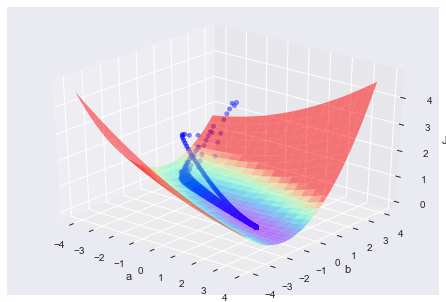

In [70]:
PlotPath(x,y,z,angle=310)

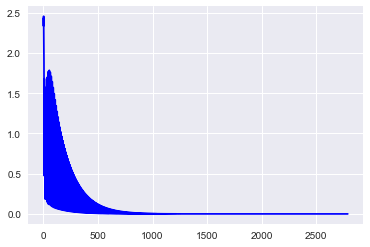

In [72]:
PlotErrorCurve(z)

## 问题及挑战
mini-batch gradient descent 无法保证好的收敛性，并且留下了一些挑战：

* 选择适当的学习率是一个难题。太小的学习率会导致较慢的收敛速度，而太大的学习率则会阻碍收敛，并会引起罚函数在最小值处震荡，甚至有可能导致结果发散。

* 调整学习率的两种方法：1.我们可以设置一个关于学习率的列表，通过如退火的方法，在学习过程中不断调整学习率；2. 当每次迭代中目标函数的变化小于一定阈值时来降低学习率。但这些列表或阈值，需要根据数据集的特性，被提前定义。

* 此外，我们对所有的参数都采用了相同的学习率。但如果我们的数据比较稀疏，同时特征有着不同的出现频率，那么我们不希望以相同的学习率来更新这些变量，我们希望对较少出现的特征有更大的学习率。

* 在对神经网络最优化高度非凸的惩罚函数时，另一个通常面临的挑战，是如何避免目标函数被困在无数的局部最小值中，以导致的未完全优化的情况。Dauphin 及其他人 [19] 认为，这个困难并不来自于局部最小值，而是来自于「鞍点」，也就是在一个方向上斜率是正的、在一个方向上斜率是负的点。这些鞍点通常处于函数值相同的平面上，鞍点附近各个方向的梯度值都接近于0，所以 SGD 很难从这些鞍点中逃离。

# 梯度下降的优化算法
我们不会讨论那些不能应用于高维数据集的方法，例如牛顿法等针对二阶问题的方法。
## Momentum 动量法
SGD 很难在陡谷——一种在一个方向的弯曲程度远大于其他方向的表面弯曲情况——中找到正确更新方向。而这种陡谷，经常在局部极值中出现。在这种情况下，如下图所示，SGD 在陡谷的周围震荡，向局部极值处缓慢地前进。
![without_momentum](http://sebastianruder.com/content/images/2015/12/without_momentum.gif)

动量法，如下图所示，则帮助 SGD 在相关方向加速前进，并减少它的震荡。
![with_momentum](http://sebastianruder.com/content/images/2015/12/with_momentum.gif)

将之前的梯度方向，通过一个折损系数$\gamma$，加入到当前的梯度方向，来实现这样的功能：

$v_t=\gamma v_{t-1}+\eta\frac{\partial J(\theta)}{\partial \theta}$

$\theta=\theta-v_t$


In [75]:
# Batch gradient descent
@exeTime
def Batch_gradient_descent_momentum(train,label,a=-3,b=4,tolerance=1e-3,maxiter=1000,gamma=0.9):
    pre_a=100;pre_b=100;alpha=1;iteration=0
    va=0;vb=0
    x=[];y=[];z=[]
    while(((abs(a-pre_a)>tolerance) and abs(b-pre_b)>tolerance) and iteration<maxiter):
        iteration+=1;J_val=0;djda=0;djdb=0
        for ind,i in enumerate(train):
            J_val+=J(i,label[ind],a,b)
            tmp1,tmp2=dJ(i,a,b)
            djda+=tmp1;djdb+=tmp2
        djda=djda/len(train); djdb=djdb/len(train)
        x.append(a);y.append(b);z.append(J_val/len(train))
        # 改动
        va=gamma*va+alpha*djda
        vb=gamma*vb+alpha*djdb
        pre_a=a;pre_b=b
        # 梯度下降
        a-=va;b-=vb
    print ('a:',a); print ('b:',b); print ('iteration:',iteration)
    return x,y,z


In [76]:
x,y,z=Batch_gradient_descent_momentum(train,label,tolerance=1e-6,gamma=0.8)

@09:41:40, {Batch_gradient_descent_momentum} start
a: 1.9998480537801577
b: -0.9998957551175368
iteration: 96
@09:41:41, {Batch_gradient_descent_momentum} end
@1.400s taken for {Batch_gradient_descent_momentum}


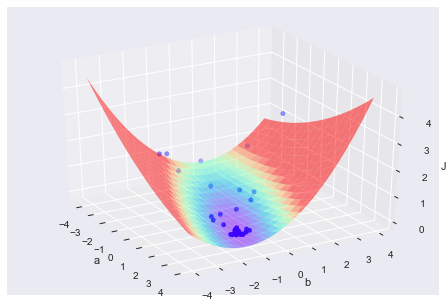

In [77]:
PlotPath(x,y,z,angle=330)

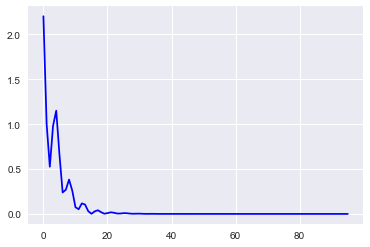

In [78]:
PlotErrorCurve(z)

### 加速原理
动量项$\gamma v_{t-1}$会加速相同梯度方向下的参数更新，阻碍梯度方向发生改变情况下的参数更新。因此我们得到了更快的收敛速率和更小的波动

> The same thing happens to our parameter updates: The momentum term increases for dimensions whose gradients point in the same directions and reduces updates for dimensions whose gradients change directions. As a result, we gain faster convergence and reduced oscillation.

## Nesterov accelerated gradient （Nesterov加速梯度法）
Momentum方法相当于一个球从山坡上滚下，虽然能够滚到谷底（收敛到最小值），但是这个过程完全依赖于山谷的形状（目标函数的参数空间），这样的小球不够聪明。一个聪明的小球不仅应该知道前进的方向，还应该知道当山坡斜率再次上升的时候减速。

NAG能帮助我们实现这种能力。

传统的动量方法通过梯度项和动量项两部分对当前参数做出修改（移动位置）

$v_t=\gamma v_{t-1}+\eta\nabla_\theta J(\theta)$

如果只计算动量项，我们可以得到参数下一个位置的粗略的近似值。

$\theta_t=\theta_{t-1}-\gamma v_{t-1}$

NAG通过修改梯度项达到最终效果，NAG计算的不是当前位置的梯度，而是计算通过动量项得到的下一个参数近似位置的梯度。

$v_t=\gamma v_{t-1}+\eta\nabla_\theta J(\theta-\gamma v_{t-1})$

NAG的这种策略能防止参数“走得太快”导致的高“敏感度”。达到了更好的表现。

直观地，动量法首先计算当前的梯度值（小蓝色向量），然后在更新的积累向量（大蓝色向量）方向前进一大步。但 NAG 法则首先（试探性地）在之前积累的梯度方向（棕色向量）前进一大步，再根据当前地情况修正，以得到最终的前进方向（绿色向量）。这种基于预测的更新方法，使我们避免过快地前进.(Source: [G. Hinton's lecture 6c](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf))
![NAG](http://www.clipular.com/c/5788258496937984.png?k=HCEshveDChOH1wY34Vo9wSuU32A)

In [79]:
# Batch gradient descent
@exeTime
def Batch_gradient_descent_NAG(train,label,a=-3,b=4,tolerance=1e-3,maxiter=1000,gamma=0.9):
    # 参数的初始化
    pre_a=100;pre_b=100;alpha=1;iteration=0
    va=0;vb=0
    x=[];y=[];z=[]
    while(((abs(a-pre_a)>tolerance) and abs(b-pre_b)>tolerance) and iteration<maxiter):
        iteration+=1;J_val=0;djda=0;djdb=0
        for ind,i in enumerate(train):
            J_val+=J(i,label[ind],a,b)
            # 改动
            tmp1,tmp2=dJ(i,a-gamma*va,b-gamma*vb)
            djda+=tmp1;djdb+=tmp2
        djda=djda/len(train); djdb=djdb/len(train)
        x.append(a);y.append(b);z.append(J_val/len(train))
        va=gamma*va+alpha*djda
        vb=gamma*vb+alpha*djdb
        pre_a=a;pre_b=b
        a-=va;b-=vb
    print ('a:',a); print ('b:',b); print ('iteration:',iteration)
    return x,y,z


In [80]:
x_m,y_m,z_m=Batch_gradient_descent_NAG(train,label,tolerance=1e-6,gamma=0.8)

@09:42:01, {Batch_gradient_descent_NAG} start
a: 1.9999813749307995
b: -0.9999934488732389
iteration: 98
@09:42:02, {Batch_gradient_descent_NAG} end
@1.471s taken for {Batch_gradient_descent_NAG}


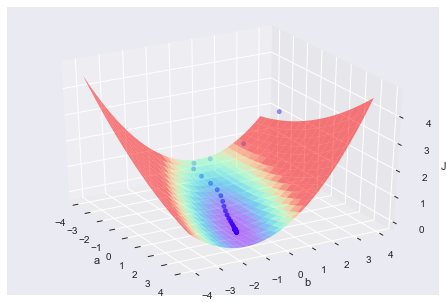

In [81]:
PlotPath(x_m,y_m,z_m,angle=330)

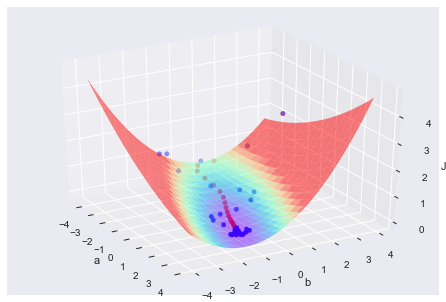

In [84]:
# 绘制梯度下降路径
angle=330
plt.clf()
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(grid_a, grid_b, grid_J,rstride=1, cstride=2,vmax=1, cmap='rainbow',alpha=0.5)
#坐标轴
ax.set_zlabel('J'); ax.set_ylabel('b'); ax.set_xlabel('a'); p1=ax.scatter(x,y,z,c='b');p1=ax.scatter(x_m,y_m,z_m,c='r')
ax.view_init(30, angle)
plt.draw()

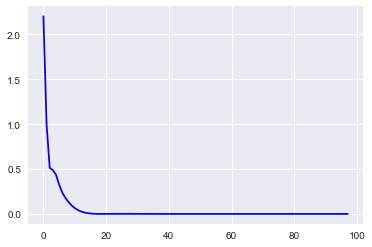

In [86]:
PlotErrorCurve(z_m)

## 小结及过渡

到现在，我们实现了：

* 根据目标函数形成的超平面，来更新我们的参数，最终求解出最优值。
* 对梯度下降的加速。

然而我们希望针对不同的参数按照其重要性的不同，采取不同的更新策略。

In [87]:
# 生成不平衡的测试数据
from itertools import product
import numpy as np

# train_unbalanced=list(product([0.01*i for i in range(1,100)], [0.1*i for i in range(1,100)]))
train_unbalanced=list(combinations([0.01*i for i in range(150)], 2))
print(np.shape(train_unbalanced))
train_unbalanced=train_unbalanced[:4950]
label_unbalanced=[]
for i in train_unbalanced:
    label_unbalanced.append(4*i[0] -16*i[1])
print(np.shape(train_unbalanced))
print(train_unbalanced[:5])
print(label_unbalanced[:5]) 
print(train_unbalanced[-1])
print(label_unbalanced[:1]) 

# 计算参数空间内，每一个坐标所对应的函数值
def PlotJ_new(train,label,a,b):
    J=np.zeros(np.shape(a))
    for ind,i in enumerate(train):
        Z_pre=np.array((a**2)*i[0] -(b**2)*i[1])
        Z=label[ind]
        J+=0.5*(Z_pre-Z)**2
    return J/len(train)

# 绘制参数空间中，目标函数的变化值
plota = np.arange(-6, 6, 0.25)
plotb = np.arange(-6, 6, 0.25)
plota, plotb = np.meshgrid(plota, plotb)

# plotJ_unbalanced

plotJ_unbalanced=PlotJ_new(train_unbalanced,label_unbalanced,plota,plotb)

(11175, 2)
(4950, 2)
[(0.0, 0.01), (0.0, 0.02), (0.0, 0.03), (0.0, 0.04), (0.0, 0.05)]
[-0.16, -0.32, -0.48, -0.64, -0.8]
(0.37, 1.4000000000000001)
[-0.16]


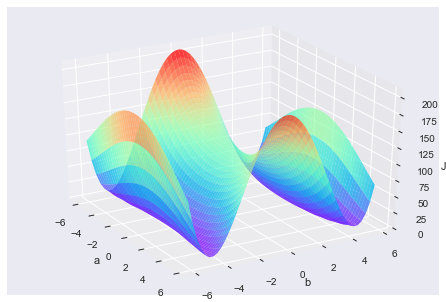

In [88]:
plt.clf()
fig = plt.figure()
ax = Axes3D(fig)
ax.set_zlabel('J') #坐标轴
ax.set_ylabel('b')
ax.set_xlabel('a')
# 具体函数方法可用 help(function) 查看，如：help(ax.plot_surface)
ax.plot_surface(plota, plotb, plotJ_unbalanced, rstride=1, cstride=1, cmap='rainbow',alpha=0.75)
ax.view_init(30, 330)
plt.draw()

## Adagrad
Adagrad实现了这样的作用：
调整参数的学习率(learning rate)，为不经常出现的参数采用更大的更新，经常出现的采用较小的更新。因此，很适合于处理稀疏数据。

Adagrad极大地提高了SGD的robustness，被用在了google的 "*learned to recognize cats in Youtube videos*" 

前面我们同时对所有的参数$\theta$（实验中的a,b）进行一次更新，使用相同的学习率$\eta$。

在Adagrad中，对每一个参数$\theta_i$在每一个时刻$t$采用不同的学习率。将目标函数对于参数$\theta_i$在第$t$步的导数值记为$g_{t,i}$

$$g_{t,i}=\nabla_\theta J(\theta_i)$$

则可以对每个变量做出分别的更新：

$$\theta_{t+1,i}=\theta_{t,i}-\eta g_{t,i}$$

相比于之前介绍的方法，学习率保持不变，Adagrad对每一步的学习率都会做出修改，这一修改基于之前每一步的梯度情况。

$$\theta_{t+1,i}=\theta_{t,i}-\frac{\eta}{\sqrt{G_{t,ii}+\epsilon}} g_{t,i}$$

$G_t$是一个对角矩阵，第$i$个对角元$G_{t,ii}$代表参数$\theta_i$到第$t$步所有梯度平方的和。$\epsilon$是一个平滑项（smoothing term，usually on the order of $1e^{−8}$），防止分母为0的情况出现。不开方的时候，算法会变得更糟。

我们可以将整个参数更新过程写成矩阵运算的形式：

$$\theta_{t+1}=\theta_{t}-\frac{\eta}{\sqrt{G_{t}+\epsilon}}\odot g_{t}$$



In [89]:
from __future__ import division
from copy import copy
@exeTime
def BGD_Matrix(train,label,a=-3.0,b=4.0,tolerance=1e-3,maxiter=1000,elta=0.9):
    # 参数的初始化
    alpha=1;iteration=0
    theta=np.array([float(a),float(b)])
    theta_pre=np.array([100.0,100.0])
    x=[];y=[];z=[]
    
    while((sum(abs(theta-theta_pre))>tolerance) and iteration<maxiter):
        iteration+=1;J_val=0;grad=np.array([0.0,0.0])
        for ind,i in enumerate(train):
            tmp=np.array([i[0],-i[1]])
            
            J_val+=0.5*((theta**2).dot(tmp)-label[ind])**2
            grad+=((theta**2).dot(tmp)-label[ind])*(2*theta*tmp)
        
        grad=grad/len(train)
        x.append(theta[0]);y.append(theta[1]);z.append(J_val/len(train))
        theta_pre=copy(theta)
        theta-=float(elta)*grad

    print ('a:',theta[0]); print ('b:',theta[1]); print ('iteration:',iteration)
    return x,y,z

In [90]:
x,y,z=BGD_Matrix(train_unbalanced,label_unbalanced,a=4,b=0.001,elta=0.01)

@09:47:02, {BGD_Matrix} start
a: 0.726817411123
b: 3.92097418266
iteration: 48
@09:47:04, {BGD_Matrix} end
@1.881s taken for {BGD_Matrix}


In [91]:
# 绘制梯度下降路径
def PlotPath_new(x,y,z,plota=plota, plotb=plotb, plotJ=plotJ,zlim=None,angle=300,vmax=1,alpha=0.5):
    plt.clf()
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(plota, plotb, plotJ,rstride=1, cstride=2,vmax=vmax, cmap='rainbow',alpha=alpha)
    #坐标轴
    ax.set_zlabel('J'); ax.set_ylabel('b'); ax.set_xlabel('a'); ax.scatter(x,y,z,c='b')
    if zlim:
        ax.set_zlim(0, zlim)
#     plt.show()
    
    ax.view_init(30, angle)
    plt.draw()

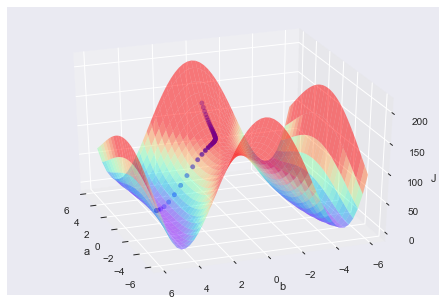

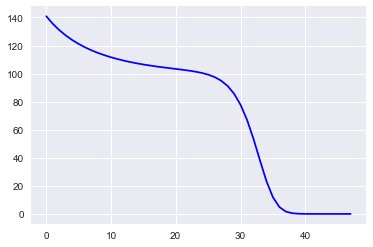

In [92]:
PlotPath_new(x,y,z,angle=160,plotJ=plotJ_unbalanced,alpha=0.5,vmax=100)
PlotErrorCurve(z)

In [93]:
@exeTime
def Adagrad(train,label,a=-3.0,b=4.0,tolerance=1e-3,maxiter=500,elta=0.9,e=1e-8):
    # 参数的初始化
    iteration=0
    theta=np.array([float(a),float(b)])
    theta_pre=np.array([100.0,100.0])
    x=[];y=[];z=[]
    G=np.zeros((len(theta)))
    
        
    while((sum(abs(theta-theta_pre))>tolerance) and iteration<maxiter):
        iteration+=1;J_val=0;grad=np.array([0.0,0.0])
        for ind,i in enumerate(train):
            tmp=np.array([i[0],-i[1]])

            J_val+=0.5*((theta**2).dot(tmp)-label[ind])**2
            grad+=((theta**2).dot(tmp)-label[ind])*(2*theta*tmp)
        
        grad=grad/len(train)
        G+=grad**2
        alpha=elta/((G+e)**0.5)
        x.append(theta[0]);y.append(theta[1]);z.append(J_val/len(train))
        theta_pre=copy(theta)
        theta-=alpha*grad
    print ('a:',theta[0]); print ('b:',theta[1]); print ('iteration:',iteration)
    return x,y,z

In [94]:
x,y,z=Adagrad(train_unbalanced,label_unbalanced,a=4,b=0.001)

@09:48:11, {Adagrad} start
a: 1.88673960902
b: 3.98988615325
iteration: 13
@09:48:11, {Adagrad} end
@0.526s taken for {Adagrad}


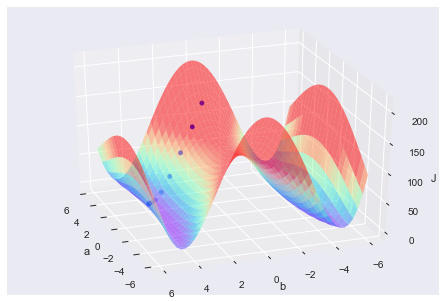

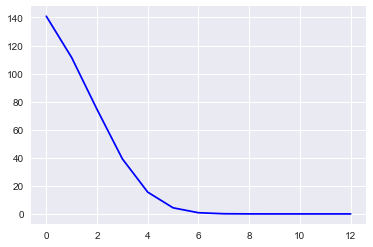

In [95]:
PlotPath_new(x,y,z,angle=160,plotJ=plotJ_unbalanced,vmax=100)
PlotErrorCurve(z)

## 小结

### 优点
Adagrad最大的优点是不用手动调整learning rate，大部分的算法实现都把学习率固定在0.01

综上可以看出，adagrad可以更快的避开鞍点，收敛到最小值

### 局限

Adagrad的主要局限在于其在分母上对平方梯度的累加，因为每一次累加项都是正的，所以最终学习率会变成无穷小，此时算法无法再学习到额外的知识了。（后期收敛速度会变慢。解决方法：restart）

## Adadelta

added citation from [Physcalの大魔導書](http://www.cnblogs.com/neopenx/p/4768388.html) and [ADADELTA: An Adaptive Learning Rate Method](https://arxiv.org/abs/1212.5701)

Adadelta 是对 Adagrad 的一个拓展，它主要解决Adagrad的学习率单调下降的问题。相比计算之前所有梯度的平方和，Adadelta 仅计算在一个大小为$\omega$的时间区间内梯度值的累积和。

相较于存储$\omega$个先前梯度的平方值这种低效率的解决方案，梯度平方和被递归的定义为过去梯度值的衰减均值(decaying average)，当前时间的梯度均值$E[g^2]_t$是基于过去梯度均值$E[g^2]_{t-1}$和当前梯度值平方$g^2$，定义公式如下，其中$\gamma$类似上述动量项的权值,一般设置为0.9。

> 当$\gamma$取0.5时，这个式子就变成了求梯度平方和的平均数（貌似不严谨，应该只是取了当前步骤的平均数，而非从0到t所有导数的平均数）

$$E[g^2]_t=\gamma E[g^2]_{t-1} + (1-\gamma)g_t^2$$

参数的更新变为

$\theta_{t+1}=\theta_{t}-\frac{\eta}{\sqrt{E[g^2]_t+\epsilon}}\odot g_{t}$

考虑到分母项就是梯度的均方根（root mean squared RMS），若将 $\sqrt{E[g^2]_t+\epsilon}$ 记为 $RMS[g]_t$ 为可以简写一下上述公式为


$\theta_{t+1}=\theta_{t}-\frac{\eta}{RMS[g]_t}\odot g_{t}$

注意到量纲在参数更新的过程中不一致，也就是说，更新值的量纲与参数值的假设量纲并不一致（分数惹的祸 $\frac{\eta}{RMS[g]_t}$）。同样的问题发生在SGD，Momentum 和 Adagrad中。

为解决这一问题，定义另外一种指数衰减的衰减均值，他是基于参数更新的平方而非梯度的平方来定义的：

$E[\Delta\theta^2]_t=\gamma E[\Delta\theta^2]_{t-1} + (1-\gamma)\Delta\theta_t^2$

对应的均方根为：

 $RMS[\Delta\theta]_t=\sqrt{E[\Delta\theta^2]_t+\epsilon}$
 
 $\theta_{t+1}=\theta_{t}-\frac{RMS[\Delta\theta]_t}{\sqrt{E[g^2]_t+\epsilon}}\odot g_{t}$
  

 ![Ada](http://www.clipular.com/c/6479940968251392.png?k=NGIEWiHekfVAFtGWJ7mpiXmeswk)

In [122]:
@exeTime
def AdaDelta(train,label,a=-3.0,b=4.0,tolerance=1e-3,maxiter=100,elta=0.9,e=1e-8,rho=0.9):
    # 参数的初始化
    iteration=0
    theta=np.array([float(a),float(b)])
    theta_pre=np.array([100.0,100.0])
    x=[];y=[];z=[]
    E_g_2=np.zeros((len(theta)))
    E_DeltaTheta_2=np.zeros((len(theta)))
    DeltaTheta=np.zeros((len(theta)))
    gms=np.zeros((len(theta)))
    con=0
    
    while((sum(abs(theta-theta_pre))>tolerance) and iteration<maxiter):
        iteration+=1;J_val=0;grad=np.array([0.0,0.0])
        for ind,i in enumerate(train):
            tmp=np.array([i[0],-i[1]])

            J_val+=0.5*((theta**2).dot(tmp)-label[ind])**2
            grad+=((theta**2).dot(tmp)-label[ind])*(2*theta*tmp)
        
        grad=grad/len(train)
        
        gms = (rho * gms) + (1 - rho) * grad ** 2
        step = (elta / ((gms + e)**0.5))* grad 
#         print(step)
        theta -= step

#         sms = (rho * sms) + (1 - rho) * step ** 2

        

        x.append(theta[0]);y.append(theta[1]);z.append(J_val/len(train))
#         theta_pre=copy(theta)

#         theta+=DeltaTheta
    print ('a:',theta[0]); print ('b:',theta[1]); print ('iteration:',iteration)
    return x,y,z

In [123]:
x,y,z=AdaDelta(train_unbalanced,label_unbalanced,a=4,b=0.001,rho=0.3,tolerance=1e-2)

@10:02:07, {AdaDelta} start
a: 0.242373985735
b: 4.30412694612
iteration: 100
@10:02:11, {AdaDelta} end
@3.856s taken for {AdaDelta}


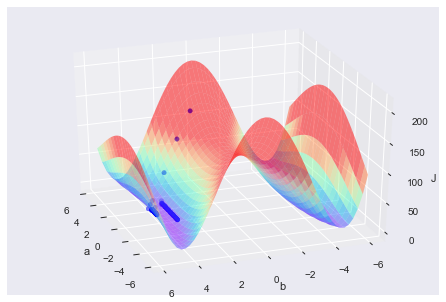

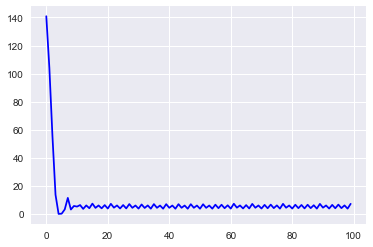

In [124]:
PlotPath_new(x,y,z,angle=160,plotJ=plotJ_unbalanced,vmax=100)
PlotErrorCurve(z)